# Linear and non-linear fitting in Python
####     *Author: Davide Dal Bosco*

The aim of this notebook is to show a simple way to perform **linear** and **non-linear fitting** in Python. 

The main functions that are considered here are ``numpy.polyfit`` and ``scipy.optimize.curve_fit``.

Both these function return the optimal parameters and optionally the **covariance matrix**, which is useful to estimate the uncertainty on the fit parameters. Indeeed, under reasonable assumptions (everything is gaussian and uncorrelated), the uncertainties on the fit paramters can be estimated as the square root of the diagonal elements of the covariance matrix $\mathbf{C}=\left[c_{ij}\right]$:

\begin{equation}
\sigma_i= \sqrt{c_{ii}}
\end{equation}

**Pro tip \#1:** even if nobody actually wants to do it, reading the documentation can sometimes be helpful

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

**Pro tip \#2:** when in doubt, be *conservative*, aka *overestimate*, the uncertainties.


**Getting Python:** if you do not want to go through the hassle of managin yourself the packages that you need to make stuff work, I suggest you download a Python distribution, such as Anaconda

https://www.anaconda.com/products/individual

In [1]:
# Noteebook magic
%matplotlib notebook

# Import the packages that we need
import matplotlib.pyplot as plt    # package to plot stuff
import numpy as np    # package to generate and manipulate MATLAB-like matrices

from scipy.optimize import curve_fit    # Function to make linear or non-linear fitting

# Use latex for labels
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern']})
rc('text', usetex=True)

## Linear fitting

Here is an example of a linear fit with synthetic data. I will do the same fit with  ``numpy.polyfit`` and ``scipy.curve_fit`` and then compare the results.

<IPython.core.display.Javascript object>


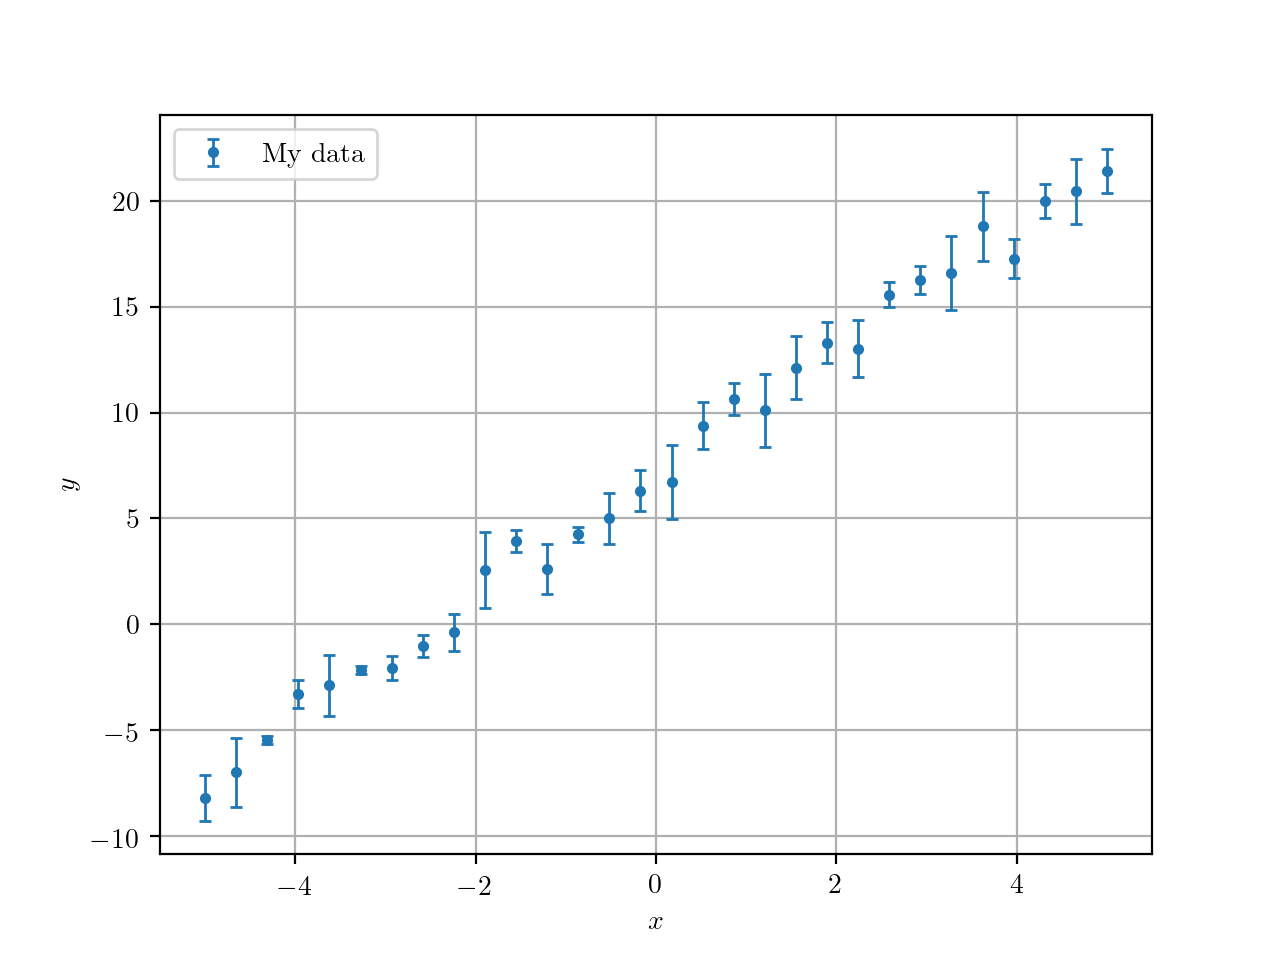

In [11]:
# Generate synthetically the data
# True parameters

true_slope = 3
true_intercept = 7

x_data = np.linspace(-5, 5, 30)

# The y-data will have a noise term, to simulate imperfect observations
sigma = 1
y_data = true_slope * x_data + true_intercept
y_obs = y_data + np.random.normal(loc=0.0, scale=sigma, size=x_data.size)

# Here I generate artificially some unequal uncertainties (even if there is no reason for them to be so)
y_uncertainties = sigma * np.random.normal(loc=1.0, scale=0.5*sigma, size=x_data.size)

# Plot the data
plt.figure()
plt.errorbar(x_data, y_obs, xerr=None, yerr=y_uncertainties, marker='.', capsize=2, elinewidth=1, 
             markeredgewidth=1, linestyle='', label='My data')
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$ ')
plt.legend()
plt.show()

### Using ``polyfit``

The function ``polyfit`` is part of the ``numpy`` module. It is a tool to perform **least squares polynomial fitting**.

The most relevant inputs to be given to the ``polyfit`` are:
- The $x$-coordinates of the data.
- The observed $y$-values.
- The degree of the polinomial fit (``1`` = linear fit, ``2`` = parabolic fit, ...).
- ``w`` *(optional)*: a quantity reled to the weights of the fit. A common choice for the weights are the inverse of the square of the uncertainties on the $y$-data (https://en.wikipedia.org/wiki/Weighted_least_squares). The documentation advises to use $w_i = 1/\sigma_i$ (and not $1/\sigma_i^{2}$) to do the usual weighted least square fit. This is due to the fact that, at the time of writing, the weigths are squared inside the function. Mathematically the cost function optimized in the weighted least squares fit is
\begin{equation}
    \underbrace{\sum_i \left\lbrace w_i \cdot \left[p(x_i) - y_i \right]\right\rbrace^2}_{\texttt{polyfit}}\qquad\longleftrightarrow\qquad\underbrace{\sum_i \frac{\left[p(x_i) - y_i \right]^2}{\sigma_i^2}}_{\mbox{Weighted least squares}}
\end{equation}
For details see https://github.com/numpy/numpy/issues/5261.

- ``cov`` *(optional)*: argument to return the covariance matrix. 
 * If ``cov=False`` (default), no covariance matrix is provided.
 * If ``cov=True``, the covariance are scaled by $\frac{\chi^2}{\mbox{DOF}}$, where $\chi^2$ is the chi-squared value of the fit. This means that the weights are presumed to be unreliable except in a relative sense and everything is scaled such that the reduced $\chi^2$ is unity. 
 * If ``cov=unscaled``, the scaling mentioned before is ignored, as is relevant for the case that the sigmas $\sigma$ used as weights are a *reliable* estimate of the uncertainty. This last case is what I consider here.

``polyfit`` then returns:
- An array containing the optimal parameters. The parameters are ordered from the highest power to the lowest power term of the polynomial (last is the intercept). 
- *(optional)* the covariance matrix of the parameters.

For more information, have a look at the documentation 
https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

In [12]:
# Weghted linear fitting with numpy.polyfit

popt, pcov = np.polyfit(x_data, y_obs, 1, w=1/y_uncertainties, cov='unscaled')
p_err = np.sqrt(np.diag(pcov))    # error on fit parameters

# Report
print('************************ RESULTS ************************')
print('The optimal parameters (with 68% confidence) are:')
print('Slope:     %f +/- %f [True value is %f]' % (popt[0], p_err[0], true_slope))
print('Intercept: %f +/- %f [True value is %f]' % (popt[1], p_err[1], true_intercept))

************************ RESULTS ************************
The optimal parameters (with 68% confidence) are:
Slope:     2.932590 +/- 0.041340 [True value is 3.000000]
Intercept: 7.264939 +/- 0.138462 [True value is 7.000000]


### Using ``curve_fit``
The function ``curve_fit`` is part of the ``scipy`` module. It is a tool to perform **least squares fitting** of virtually any function!

The most relevant inputs to be given to the ``curve_fit`` are:
- The model function, $f(x, \ldots)$. It must take the independent variable as the first argument and the parameters to fit as separate remaining arguments. If must be defined in advance.
- The $x$-coordinates of the data.
- The observed $y$-values.
- ``p0`` *(optional)*: array containig the initial guess for the parameters. If ``None``, then the initial values will all be $1$.
- ``sigma`` *(optional)*: determines the uncertainty in the $y$-data. The values in the array are used to compute the weights of the fit. Notice this important difference with respect to ``polyfit``: here the uncertainties are directly provided, rather than the weights! If ``sigma=None`` all the data points have same weight.
- ``absolute_sigma`` *(optional)*: argument to define how the covariance matrix is scaled.
 * If ``absolute_sigma=True``, ``sigma`` is used in an absolute sense and the estimated parameter covariance reflects these absolute values. Use this option if the uncertainties in ``sigma`` are reliable estimates of the data errors.
 * If ``absolute_sigma=False`` (default), only the relative magnitudes of the ``sigma`` values matter. The returned parameter covariance matrix is based on scaling sigma by a constant factor. This constant is set by demanding that the reduced $\chi^2$ for the optimal parameters when using the scaled sigma equals unity. In other words, sigma is scaled to match the sample variance of the residuals after the fit (the scaling factor is as before $\frac{\chi^2}{N - M} = \frac{\chi^2}{\mbox{DOF}}$ ($N$ is the number of datapoints and $M$ is the number of fit parameters).

``curve_fit`` then returns:
- An array containing the optimal parameters. The parameters are ordered as in the definition of the fit function.
- *(optional)* the covariance matrix of the parameters.


For more information, have a look at the documentation 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [13]:
# Same stuff with curve_fit
# Define fit function (it can be basically be any function)
def my_funct(x, m, q):
    return m * x + q

popt2, pcov2 = curve_fit(my_funct, x_data, y_obs, p0 = [1, 2], sigma=y_uncertainties, absolute_sigma=True)
p_err2 = np.sqrt(np.diag(pcov2))    # error on fit parameters

# Report
print('************************ RESULTS ************************')
print('The optimal parameters (with 68% confidence) are:')
print('Slope:     %f +/- %f [True value is %f]' % (popt2[0], p_err2[0], true_slope))
print('Intercept: %f +/- %f [True value is %f]' % (popt2[1], p_err2[1], true_intercept))

************************ RESULTS ************************
The optimal parameters (with 68% confidence) are:
Slope:     2.932590 +/- 0.041340 [True value is 3.000000]
Intercept: 7.264939 +/- 0.138462 [True value is 7.000000]


<IPython.core.display.Javascript object>


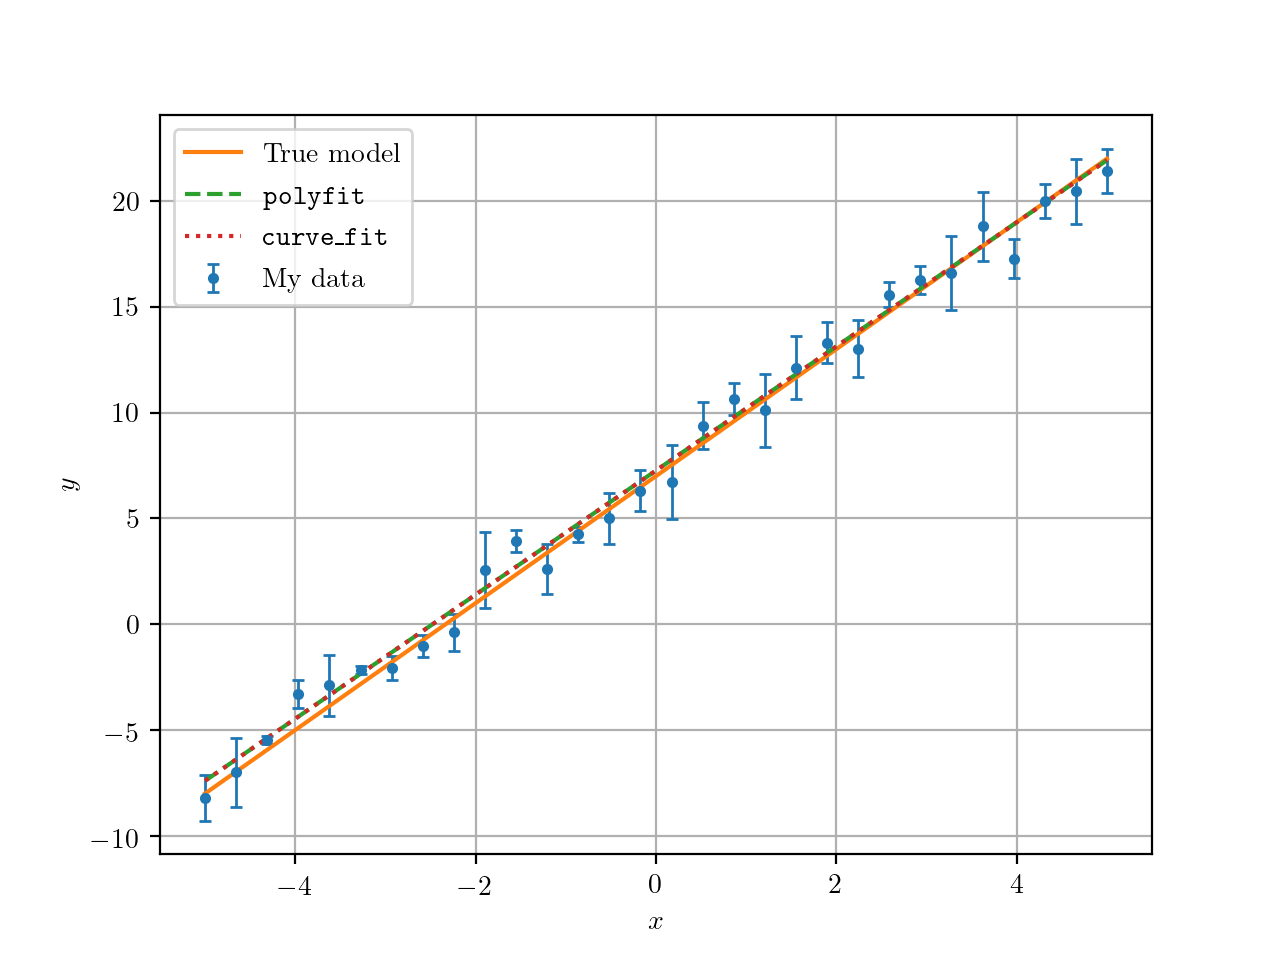

In [14]:
# Plot the data and the two fits
plt.figure()
plt.errorbar(x_data, y_obs, xerr=None, yerr=y_uncertainties, marker='.', capsize=2, 
                   elinewidth=1, markeredgewidth=1, linestyle='', label='My data')

plt.plot(x_data, y_data, label='True model')
plt.plot(x_data, popt[0] * x_data + popt[1], linestyle = '--', label=r'\texttt{polyfit}')
plt.plot(x_data, popt2[0] * x_data + popt2[1], linestyle = ':', label=r'\texttt{curve\_fit}')

plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$ ')
plt.legend()
plt.show()

With this choice of options the two function yield to the same results. 

Of course, the true model is a little different from the fit: this is due to the fact that we introduced some noise in the observations.

This may not be always  the case, as there are slight differences in how they are implemended. For example see:
https://stackoverflow.com/questions/51980910/scipy-curve-fit-vs-numpy-polyfit-different-covariance-matrices

## Non-linear fitting

Let's consider the simple example of a third-order polynomial fit to compare ``numpy.polyfit`` and ``scipy.curve_fit`` when dealing with non linear fitting. 

I would like to notice that ``numpy.polyfit`` can fit only plynomial, whereas ``scipy.curve_fit``, can be applied to basically **any function** (such as *exponentials*, *trigonometric functions*, *special functions*, *logarithms*, ...).

<IPython.core.display.Javascript object>


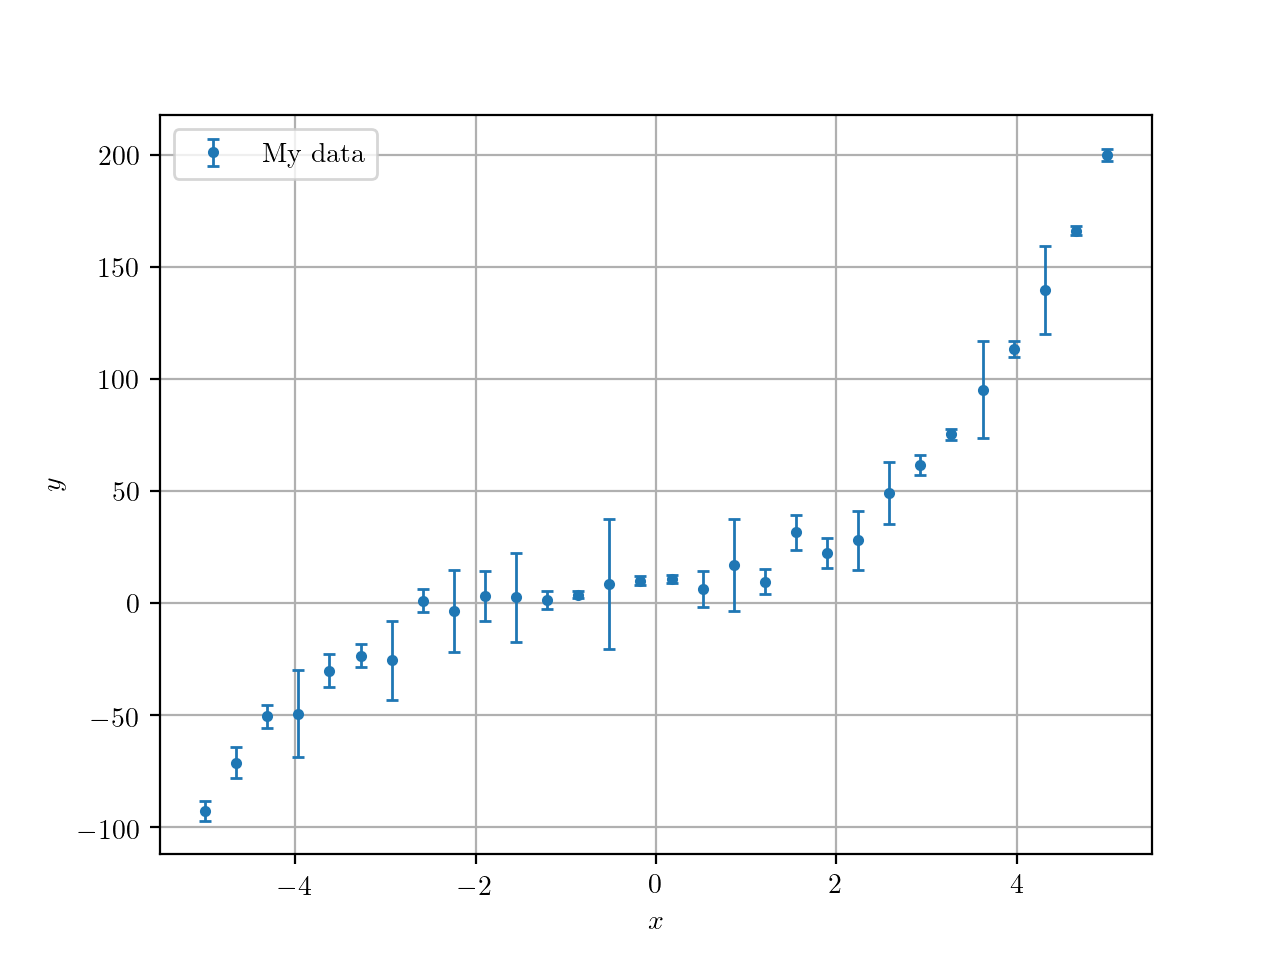

In [18]:
# Generate synthetically the data of a cubic function y = a * x^3 + b * x^2 + c * x + d
# True parameters
a = 1
b = 2
c = 4
d = 6

true_parameters = [a, b, c, d]

x_data = np.linspace(-5, 5, 30)

# The y-data will have a noise term, to simulate imperfect observations
sigma = 5
y_data = a * x_data**3 + b * x_data**2 + c * x_data + d
y_obs = y_data + np.random.normal(loc=0.0, scale=sigma, size=x_data.size)

# Here I generate artificially some unequal uncertainties (even if there is no reason for them to be so)
y_uncertainties = sigma * np.random.normal(loc=1.0, scale=0.5*sigma, size=x_data.size)

# Plot the data
plt.figure()
plt.errorbar(x_data, y_obs, xerr=None, yerr=y_uncertainties, marker='.', capsize=2, elinewidth=1, 
             markeredgewidth=1, linestyle='', label='My data')
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$ ')
plt.legend()
plt.show()

In [19]:
# Weghted polynomial fitting of order 3 with numpy.polyfit

popt, pcov = np.polyfit(x_data, y_obs, 3, w=1/y_uncertainties, cov='unscaled')
p_err = np.sqrt(np.diag(pcov))    # error on fit parameters

# Report
print('************************* RESULTS *************************')
print('The optimal parameters (with 68% confidence) are:')
for i in range(len(popt)):
    print('Parameter %d: %f +/- %f [True value is %f]' % (i, popt[i], p_err[i], true_parameters[i]))

************************* RESULTS *************************
The optimal parameters (with 68% confidence) are:
Parameter 0: 1.015417 +/- 0.039919 [True value is 1.000000]
Parameter 1: 1.807890 +/- 0.085959 [True value is 2.000000]
Parameter 2: 3.646287 +/- 0.788162 [True value is 4.000000]
Parameter 3: 8.368537 +/- 0.937459 [True value is 6.000000]


In [20]:
# Same stuff with curve_fit
# Define fit function (it can be basically be any function)
def my_cubic_funct(x, A, B, C, D):
    return A * x**3 + B * x**2 + C * x + D

popt2, pcov2 = curve_fit(my_cubic_funct, x_data, y_obs, p0 = [1, 1, 1, 2], sigma=y_uncertainties, absolute_sigma=True)
p_err2 = np.sqrt(np.diag(pcov2))    # error on fit parameters

# Report
# Report
print('************************* RESULTS *************************')
print('The optimal parameters (with 68% confidence) are:')
for i in range(len(popt2)):
    print('Parameter %d: %f +/- %f [True value is %f]' % (i, popt2[i], p_err2[i], true_parameters[i]))

************************* RESULTS *************************
The optimal parameters (with 68% confidence) are:
Parameter 0: 1.015417 +/- 0.039919 [True value is 1.000000]
Parameter 1: 1.807890 +/- 0.085959 [True value is 2.000000]
Parameter 2: 3.646287 +/- 0.788162 [True value is 4.000000]
Parameter 3: 8.368537 +/- 0.937459 [True value is 6.000000]


<IPython.core.display.Javascript object>


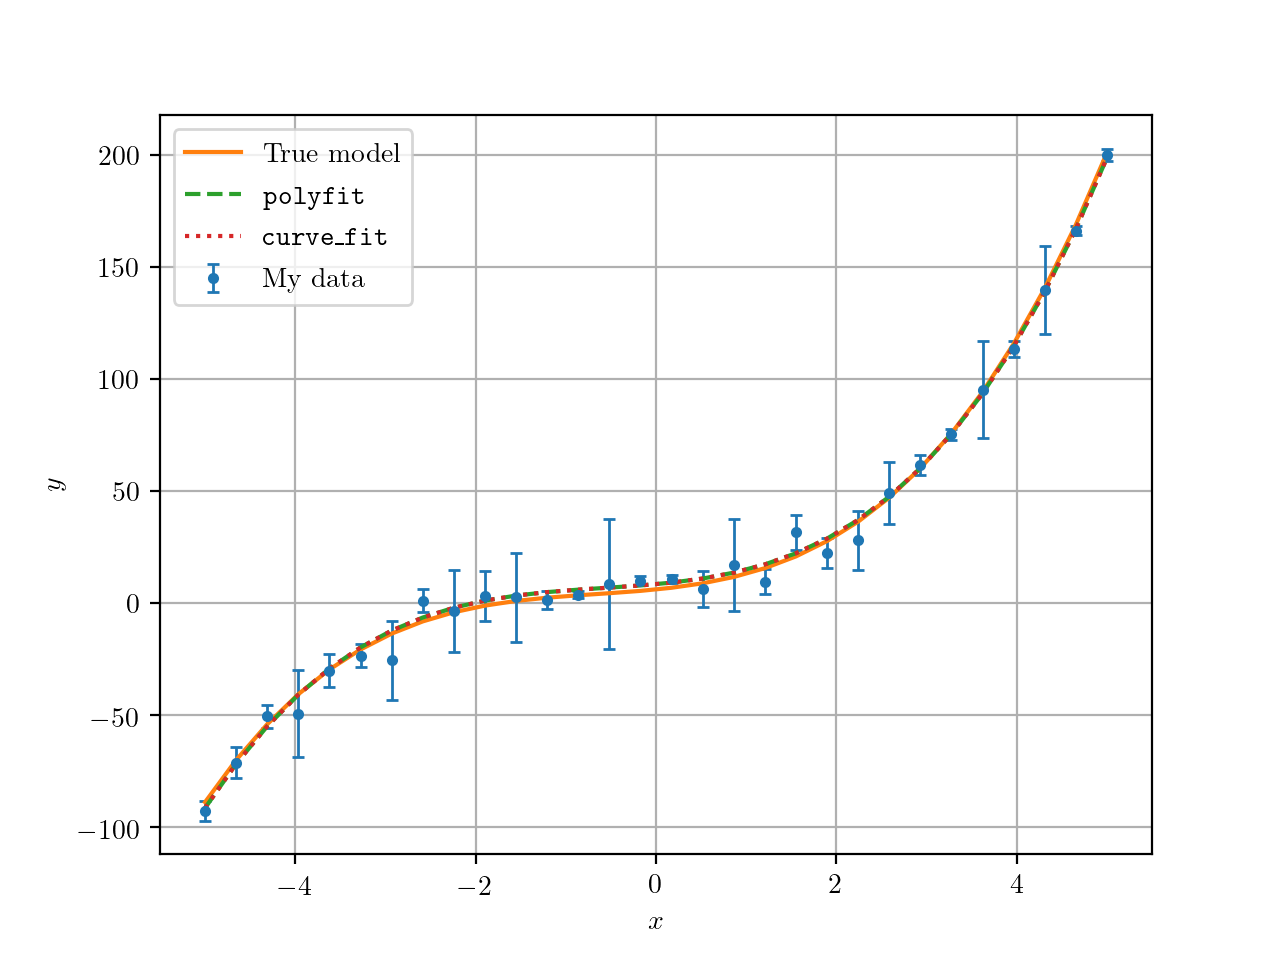

In [21]:
# Plot the data and the two fits
plt.figure()
plt.errorbar(x_data, y_obs, xerr=None, yerr=y_uncertainties, marker='.', capsize=2, 
                   elinewidth=1, markeredgewidth=1, linestyle='', label='My data')
plt.plot(x_data, y_data, label='True model')
plt.plot(x_data, popt[0] * x_data**3 + popt[1] * x_data**2 + popt[2] * x_data + popt[3], 
         linestyle = '--', label=r'\texttt{polyfit}')
plt.plot(x_data, popt2[0] * x_data**3 + popt2[1] * x_data**2 + popt2[2] * x_data + popt2[3], 
         linestyle = ':', label=r'\texttt{curve\_fit}')

plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$ ')
plt.legend()
plt.show()

## If you want to dig deeper ...
... I would suggest the Python module ``statsmodel``, which you can find at 

https://www.statsmodels.org/stable/examples/index.html

The module contains lots of functions and utilities to perform rigorous statistical analyses and tests.

Complete examples and tutorials can be found at

https://www.statsmodels.org/stable/examples/index.html